### The goal of this notebook is to reproduce the results from the original Microsim publication using the newly-developed Person-based code.

In [1]:
import os
import copy
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import numpy as np
import matplotlib.pyplot as plt

from microsim.population import NHANESDirectSamplePopulation
from microsim.risk_factor import DynamicRiskFactorsType, StaticRiskFactorsType
from collections import Counter

microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

### Validation of baseline simulated population

#### 2007-2009 NHANES

In [2]:
%%time
popSize = 100000
pop = NHANESDirectSamplePopulation(popSize, 2007)

CPU times: user 39.2 s, sys: 270 ms, total: 39.5 s
Wall time: 39.5 s


In [3]:
for i,rf in enumerate(DynamicRiskFactorsType):
    rfList = list(map( lambda x: getattr(x, "_"+rf.value)[-1] if x.is_alive else None, pop._people))
    rfList = list(filter(lambda x: x is not None, rfList))
    rfList = list(map(lambda x: int(x) if bool(x) else x, rfList))
    print(f"{rf.value:>50} {np.mean(rfList):> 6.1f}")
    
for i,rf in enumerate(StaticRiskFactorsType):
    print(f"{rf:>50}")
    rfList = list(map( lambda x: getattr(x, "_"+rf.value), pop._people))
    rfValueCounts = Counter(rfList)
    for key in rfValueCounts.keys():
        print(f"{key:>50} {rfValueCounts[key]/popSize: 6.2f}")

                                               age   45.8
                                               sbp  121.3
                                               dbp   70.7
                                               a1c    5.1
                                               hdl   52.1
                                               ldl  118.0
                                              trig  139.0
                                           totChol  196.1
                                               bmi   27.9
                               anyPhysicalActivity    0.8
                                              afib    0.0
                                             waist   97.1
                                    alcoholPerWeek    2.2
                                        creatinine    0.3
                                               pvd    0.0
              StaticRiskFactorsType.RACE_ETHNICITY
                                                 3   0.69
                     

#### 2013, hypertension

In [4]:
%%time
popSize = 100000
pop = NHANESDirectSamplePopulation(popSize, 2013, filter=lambda x: x.antiHypertensive>0)

CPU times: user 39 s, sys: 276 ms, total: 39.3 s
Wall time: 39.3 s


In [5]:
for i,rf in enumerate(DynamicRiskFactorsType):
    rfList = list(map( lambda x: getattr(x, "_"+rf.value)[-1] if x.is_alive else None, pop._people))
    rfList = list(filter(lambda x: x is not None, rfList))
    rfList = list(map(lambda x: int(x) if bool(x) else x, rfList))
    print(f"{rf.value:>50} {np.mean(rfList):> 6.1f}")
    
for i,rf in enumerate(StaticRiskFactorsType):
    print(f"{rf.value:>50}")
    rfList = list(map( lambda x: getattr(x, "_"+rf.value), pop._people))
    rfValueCounts = Counter(rfList)
    for key in rfValueCounts.keys():
        print(f"{key:>50} {rfValueCounts[key]/popSize: 6.2f}")

                                               age   60.2
                                               sbp  128.2
                                               dbp   69.6
                                               a1c    5.6
                                               hdl   51.7
                                               ldl  107.8
                                              trig  133.4
                                           totChol  185.7
                                               bmi   30.8
                               anyPhysicalActivity    0.6
                                              afib    0.1
                                             waist  106.0
                                    alcoholPerWeek    2.0
                                        creatinine    0.4
                                               pvd    0.1
                                     raceEthnicity
                                                 3   0.70
                     

### Validation of vascular risk factors over time

In [6]:
%%time
popSize = 100000
nYears = 18
pop = NHANESDirectSamplePopulation(popSize, 1999)

CPU times: user 38.6 s, sys: 241 ms, total: 38.8 s
Wall time: 38.8 s


In [7]:
%%time
#1m 47 s
pop.advance_parallel(nYears, None, 5)

CPU times: user 35.3 s, sys: 2.47 s, total: 37.8 s
Wall time: 7min 36s


In [8]:
from microsim.population import microsimToNhanes

nhanesPop = pd.read_stata(microsimDir + "/microsim/data/fullyImputedDataset.dta")
nhanesPop = nhanesPop[~(nhanesPop["timeInUS"]<4)]
nhanesPop = nhanesPop[nhanesPop["year"]==2017]
nhanesPop = nhanesPop[nhanesPop["age"]>=36]

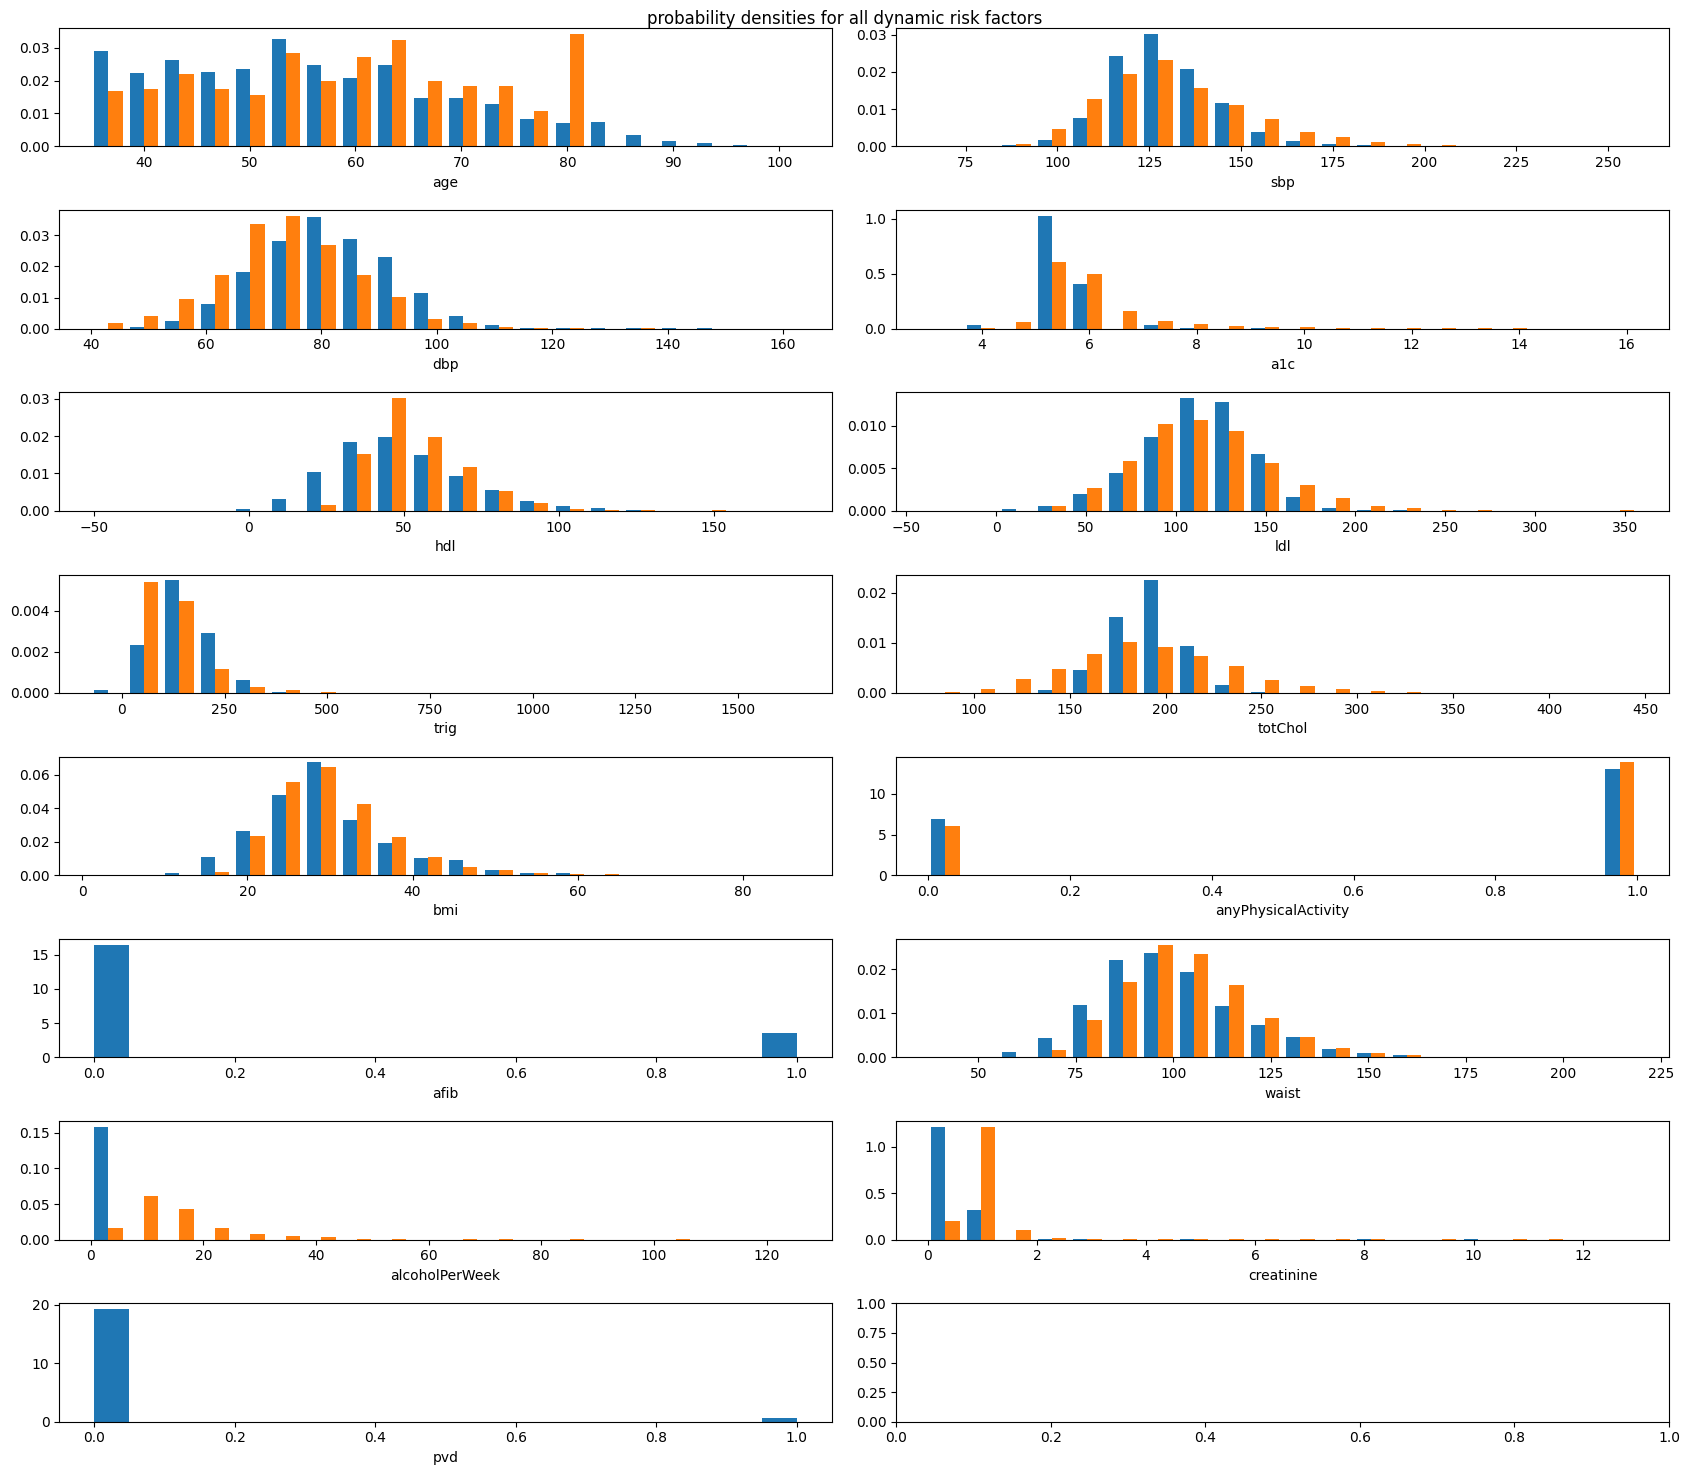

In [9]:
nRows = round(len(DynamicRiskFactorsType)/2)
fig, ax = plt.subplots(nRows, 2, figsize=(17,15))
row=-1
for i,rf in enumerate(DynamicRiskFactorsType):
    rfList = list(map( lambda x: getattr(x, "_"+rf.value)[-1] if x.is_alive else None, pop._people))
    rfList = list(filter(lambda x: x is not None, rfList))
    rfList = list(map(lambda x: int(x) if bool(x) else x, rfList))
    if i%2==0:
        row += 1
        col = 0
    else:
        col = 1
    if rf.value in microsimToNhanes.keys():
        ax[row,col].hist([rfList, nhanesPop[microsimToNhanes[rf.value]]], bins=20, density=True)
    else:
        ax[row,col].hist(rfList, bins=20, density=True)
    ax[row,col].set_xlabel(rf.value)
    #ax[row,col].set_ylabel("probability density")
plt.suptitle("probability densities for all dynamic risk factors")
#plt.subplots_adjust(wspace=0.5, hspace=0.7)
plt.tight_layout()
plt.show()

In [10]:
space = " "
print("                       sim mean   nha mean    sim sd     nha sd")
for i,rf in enumerate(DynamicRiskFactorsType):
    rfList = list(map( lambda x: getattr(x, "_"+rf.value)[-1] if x.is_alive else None, pop._people))
    rfList = list(filter(lambda x: x is not None, rfList))
    rfList = list(map(lambda x: int(x) if bool(x) else x, rfList))
    if rf.value in microsimToNhanes.keys():
        print(f"{rf.value:>20} {np.mean(rfList): 10.2f} {np.mean(nhanesPop[microsimToNhanes[rf.value]]): 10.2f}" + 
             f"{np.std(rfList): 10.2f} {np.std(nhanesPop[microsimToNhanes[rf.value]]): 10.2f}")
    else:
        print(f"{rf.value:>20} {np.mean(rfList): 10.2f} {space:>9} {np.std(rfList): 10.2f}")

                       sim mean   nha mean    sim sd     nha sd
                 age      55.92      59.43     13.60      13.07
                 sbp     129.58     131.21     14.97      20.65
                 dbp      81.42      73.77     11.60      11.94
                 a1c       5.32       6.05      0.61       1.20
                 hdl      49.18      53.65     21.41      16.13
                 ldl     112.33     114.03     30.39      37.59
                trig     153.02     121.37     70.20      91.21
             totChol     191.47     190.69     17.88      42.14
                 bmi      29.66      30.12      8.27       7.15
 anyPhysicalActivity       0.65       0.69      0.48       0.46
                afib       0.18                 0.38
               waist      99.33     102.95     18.44      16.40
      alcoholPerWeek       1.00      14.44      0.38      14.17
          creatinine       0.23       0.94      0.54       0.49
                 pvd       0.03                 0.1

### Validation of CV event incidence and mortality

In [11]:
from microsim.outcome import OutcomeType
outcomes = [OutcomeType.MI, OutcomeType.STROKE, OutcomeType.DEATH, 
            OutcomeType.CARDIOVASCULAR, OutcomeType.NONCARDIOVASCULAR, OutcomeType.DEMENTIA]
standardizedRates = list(map(lambda x: pop.calculate_mean_age_sex_standardized_incidence(x, 2016), outcomes))
standardizedRatesBlack = list(map(
                           lambda x: pop.calculate_mean_age_sex_standardized_incidence(x,2016, lambda y: y._black), 
                           outcomes))
print("standardized rates (per 100,000)    all        black   ")
for i in range(len(outcomes)):
    print(f"{outcomes[i].value:>30} {standardizedRates[i]:> 10.1f} {standardizedRatesBlack[i]:> 10.1f}") 

standardized rates (per 100,000)    all        black   
                            mi      235.1      215.8
                        stroke      151.8      266.1
                         death      854.6      968.1
                            cv      387.0      481.9
                         noncv      802.7      899.9
                      dementia      268.3      557.8


### Validation of dementia incidence

In [12]:
dementiaIncidentRate = pop.get_raw_incidence_by_age(OutcomeType.DEMENTIA)

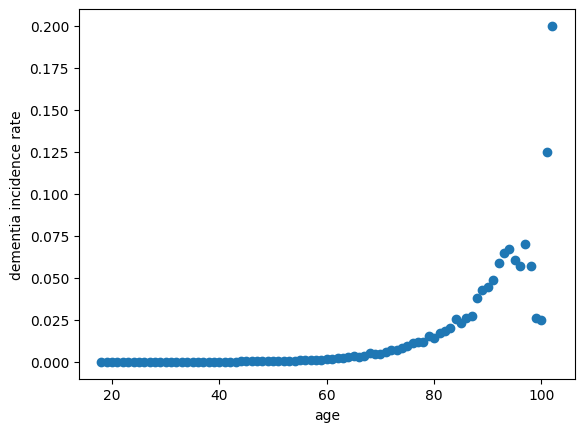

In [13]:
plt.scatter(dementiaIncidentRate.keys(), dementiaIncidentRate.values())
plt.xlabel("age")
plt.ylabel("dementia incidence rate")
plt.show()

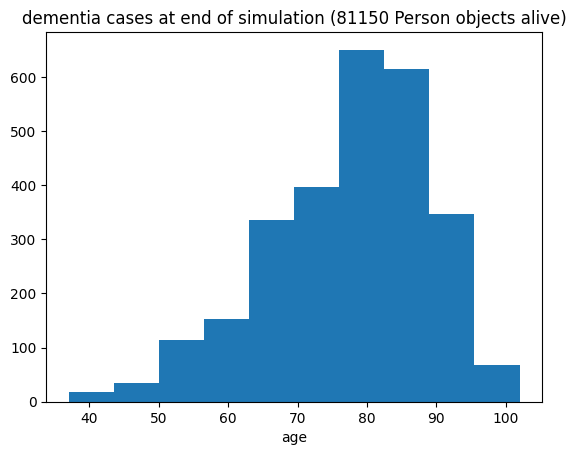

In [14]:
ageDementia = list(map(lambda y: (y._age[-1], len(y._outcomes[OutcomeType.DEMENTIA])>0), 
              list(filter(lambda x: x.is_alive, pop._people))))
nAlive = len(ageDementia)
ageDementia = list(filter(lambda x: x[1]==True, ageDementia))
ageDementia = [int(x[0]) for x in ageDementia]
plt.hist(ageDementia)
plt.xlabel("age")
plt.title(f"dementia cases at end of simulation ({nAlive} Person objects alive)")
plt.show()

### Validation of treatment effects

In [15]:
from microsim.treatment_strategy_repository import TreatmentStrategyRepository
from microsim.bp_treatment_strategies import AddASingleBPMedTreatmentStrategy, AddNBPMedsTreatmentStrategy
from microsim.treatment import TreatmentStrategiesType, TreatmentStrategyStatus
from microsim.outcome import OutcomeType

popSize = 500000
nYears=5

In [ ]:
%%time
for bpMedsAdded in [1,2,3,4]:
    treatmentPop = NHANESDirectSamplePopulation(popSize, 1999)
    controlPop = NHANESDirectSamplePopulation(popSize, 1999)
    treatmentStrategies = TreatmentStrategyRepository()
    #treatmentStrategies._repository[TreatmentStrategiesType.BP.value] = AddASingleBPMedTreatmentStrategy()
    treatmentStrategies._repository[TreatmentStrategiesType.BP.value] = AddNBPMedsTreatmentStrategy(bpMedsAdded)
    treatmentPop.advance_parallel(1, treatmentStrategies = treatmentStrategies, nWorkers=5)
    treatmentStrategies._repository[TreatmentStrategiesType.BP.value].status = TreatmentStrategyStatus.MAINTAIN
    treatmentPop.advance_parallel(nYears-1, treatmentStrategies = treatmentStrategies, nWorkers=5)
    controlPop.advance_parallel(nYears, nWorkers=5)
    
    controlRisk = sum(list(map(lambda x: x.has_outcome_during_simulation(OutcomeType.STROKE), 
                           controlPop._people)))/controlPop._n
    treatmentRisk = sum(list(map(lambda x: x.has_outcome_during_simulation(OutcomeType.STROKE), 
                             treatmentPop._people)))/treatmentPop._n
    strokeRR = treatmentRisk/controlRisk
    controlRisk = sum(list(map(lambda x: x.has_outcome_during_simulation(OutcomeType.MI), 
                           controlPop._people)))/controlPop._n
    treatmentRisk = sum(list(map(lambda x: x.has_outcome_during_simulation(OutcomeType.MI), 
                             treatmentPop._people)))/treatmentPop._n
    miRR = treatmentRisk/controlRisk
    print(f"bpMedsAdded={bpMedsAdded}, stroke RR={strokeRR}, mi RR={miRR}")

bpMedsAdded=1, stroke RR=0.7854425564291148, mi RR=0.8387725280077933


In [ ]:
#with 1bpmedsadded: 
# ref: 0.79, 0.87
#    for stroke: 0.008045, 0.0063275, 0.7865133623368552
#.   for mi: 0.0121825, 0.01068, 0.876667350707982
#with AddNBPMedsTreatmentStrategy(1)
#  ref: 0.79, 0.87
#.   for stroke: 0.0076975, 0.006165, 0.800909386164339
#.   for mi: 0.012245, 0.0105125, 0.8585136790526745
#with  AddNBPMedsTreatmentStrategy(2)
#.  ref: 0.624, 0.757
#.   for stroke: 0.0079025, 0.0044725, 0.565960139196456
#.   for mi: 0.012265, 0.0090875, 0.7409294741133307
# new params for stroke: 0.6125 for mi 0.74552
#with AddNBPMedsTreatmentStrategy(3)
#.  ref: 0.49, 0.658
#.   for stroke: 0.0077125, 0.003825, 0.495948136142625
#.   for mi: 0.0122675, 0.0079975, 0.6519258202567759
#with AddNBPMedsTreatmentStrategy(4)
#.  ref: 0.389, 0.57
#.   for stroke: 0.00801, 0.0031225, 0.3898252184769039
#.   for mi: 0.0121225, 0.0070625, 0.5825943493503816

In [ ]:
nhanesPop.columns.tolist()

In [ ]:
nhanesPop.loc[nhanesPop.apply(lambda x: x.antiHypertensive>0, axis=1)].head()